# FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import gmmPLSR_tuning
from msresist.plsr import MeasuredVsPredicted_LOOCVplot, Q2Y_across_components, R2Y_across_components
from msresist.clustering import MyOwnGMM
from msresist.sequence_analysis import FormatName
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing
from FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [2]:
pd.set_option('display.max_colwidth', 1000)

ABC_mc = preprocessing(motifs=True, Vfilter=True, FCfilter=True, log2T=True)

header = ABC_mc.columns
treatments = ABC_mc.columns[2:]

data = ABC_mc.iloc[:,2:].T
protnames = list(ABC_mc.iloc[:,1])
seqs = list(ABC_mc.iloc[:,0])

Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]
Y_cv = Y_cv[Y_cv["Elapsed"] == 72].iloc[0, 1:11]

In [3]:
ABC_mc

,peptide-phosphosite,Master Protein Descriptions,PC9,Erl,R428,Erl/R428,Erl+HGF,Erl+FGF,Erl+IGF,KO Erl,KO R428,KO Erl/R428
1,PEYGGtKVVLD,"10 kDa heat shock protein, mitochondrial",1.0,1.898469,1.236141,0.785943,1.137991,1.617113,1.521291,1.530474,2.004159,0.759164
5,GPPARsPsQDF,182 kDa tankyrase-1-binding protein,1.0,1.433001,1.081229,1.564021,1.923040,1.277516,1.702354,2.050677,2.215010,5.157213
15,---MRyVASYL,60S acidic ribosomal protein P2,1.0,1.294133,1.087464,0.843193,0.877411,0.702581,0.780621,0.933104,0.968157,2.581869
17,TYELRyFQISQ,60S ribosomal protein L22-like 1,1.0,0.928301,1.005567,1.089793,0.749455,0.932451,1.040302,0.793288,2.625435,0.920942
20,ANVIRyFPTQA,ADP/ATP translocase 2,1.0,2.071381,1.806133,1.751203,1.793197,1.503817,1.344295,1.214709,1.431357,1.545379
25,GADSDyENTQS,ARF GTPase-activating protein GIT1,1.0,2.953206,2.690775,2.121390,1.896550,2.057242,2.086118,1.659991,2.220140,1.125663
33,TVPNDyMTSPA,Abl interactor 1,1.0,1.035224,0.609739,1.111767,1.211568,1.516515,2.030137,1.354409,1.699768,1.305538
119,PAPDLyDVPPG,Breast cancer anti-estrogen resistance protein 1,1.0,2.688871,1.817244,2.930905,1.906609,2.239161,1.419946,2.544980,3.769602,2.848735
154,AAYDIsEDEED,Choline-phosphate cytidylyltransferase A,1.0,1.161905,1.011487,1.248632,1.087206,0.973957,0.901971,0.962216,4.578069,1.002359
171,PIRVYtHEVVT,Cyclin-dependent kinase 1,1.0,2.485499,1.738393,1.586359,1.492651,2.094540,0.989824,2.705262,4.350852,11.843274


### Phenotypes

#### Cell Viability:

% Confluency:

In [4]:
Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]

Optionally take the fold-change to t=0:

In [5]:
# Y_cv.iloc[:, 1:] = Y_cv.iloc[:, 1:].div(Y_cv.iloc[0, 1:], axis = 1)

Define time-point of interest:

In [6]:
Y_cv = Y_cv[Y_cv["Elapsed"] == 72].iloc[0, 1:11]

# Re-implementation using Gaussian Mixture Model clustering

In [7]:
maxComp = 4

In [8]:
kmeans = MyOwnGMM(maxComp).fit(data, Y_cv)
centers = kmeans.transform(data)

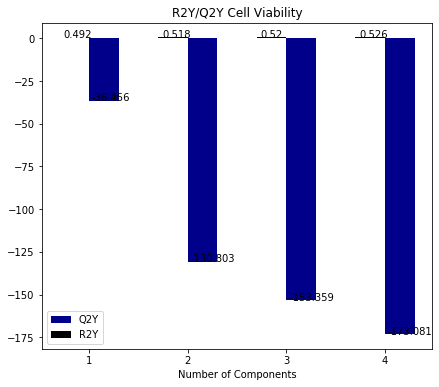

In [9]:
Q2Y = Q2Y_across_components(centers, Y_cv, maxComp+1)
R2Y = R2Y_across_components(centers, Y_cv, maxComp+1)
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

def disp_values(x,spac1,spac2,dec):
    for l, m in enumerate(x):
        plt.text(l+spac1,m+spac2,str(truncate(m,dec)))    #change to axs[ax].

range_ = np.linspace(1,maxComp,maxComp)

fig, axs = plt.subplots(1,1,figsize=(7,6))
plt.setp(axs, xticks=range_)
plt.bar(range_+0.15,Q2Y,width=0.3,align='center',label='Q2Y', color = "darkblue")
plt.bar(range_-0.15,R2Y,width=0.3,align='center',label='R2Y', color = "black")
plt.title("R2Y/Q2Y Cell Viability")
plt.xlabel("Number of Components")
plt.legend(loc=3)
disp_values(Q2Y,1.03,0.02,3)
disp_values(R2Y,0.74,0.01,3)

In [10]:
CVresults_max, CVresults_min, best_params = gmmPLSR_tuning(data, Y_cv)
CVresults_min.nlargest(30, "mean_test_scores")

,#ComponentsGMM,#ComponentsPLSR,mean_test_scores,mean_train_scores
54,11,1,-228.676982,-1.408291e+02
2,3,1,-244.069575,-1.584740e+02
0,2,1,-279.039360,-1.552471e+02
35,9,1,-285.880369,-1.448070e+02
4,3,3,-310.154346,-1.510834e+02
77,13,1,-316.911386,-1.384617e+02
27,8,1,-317.927078,-1.459917e+02
36,9,2,-318.361659,-1.113285e+02
1,2,2,-325.751106,-1.522251e+02
9,5,1,-339.359957,-1.493211e+02


In [11]:
ncl, ncomp = 4, 2

In [12]:
gmm_plsr = Pipeline([('gmm', MyOwnGMM(ncl)), ('plsr', PLSRegression(ncomp))])

In [13]:
X_scores, Y_scores = gmm_plsr.fit_transform(data, Y_cv)
PC1_scores, PC2_scores = X_scores[:, 0], X_scores[:, 1]
PC1_xload, PC2_xload = gmm_plsr.named_steps.plsr.x_loadings_[:, 0], gmm_plsr.named_steps.plsr.x_loadings_[:, 1]
PC1_yload, PC2_yload = gmm_plsr.named_steps.plsr.y_loadings_[:, 0], gmm_plsr.named_steps.plsr.y_loadings_[:, 1]

Pearson's R:  0.5007479232903792 
 p-value:  0.1404240913671269


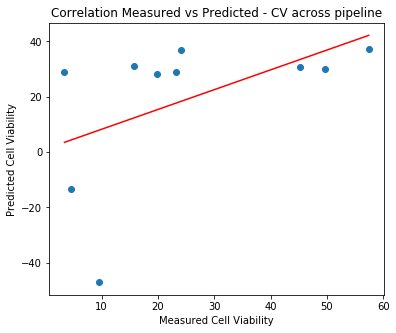

In [14]:
fig, axs = plt.subplots(1,1,figsize=(6,5))
MeasuredVsPredicted_LOOCVplot(data, Y_cv, gmm_plsr, fig, "none", axs)
plt.title("Correlation Measured vs Predicted - CV across pipeline")
plt.xlabel("Measured Cell Viability")
plt.ylabel("Predicted Cell Viability");

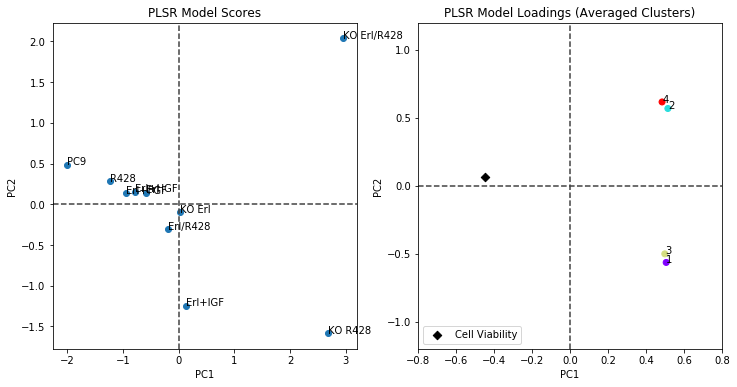

In [15]:
fig, axs = plt.subplots(1, 2,figsize=(12,6))

colors_ = cm.rainbow(np.linspace(0, 1, ncl))


axs[0].scatter(PC1_scores,PC2_scores)
for j, txt in enumerate(treatments):
    axs[0].annotate(txt, (PC1_scores[j], PC2_scores[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
# axs[0].set_xlim([-3.5, 3.5])
# axs[0].set_ylim([-1, 1])

numbered=[]
list(map(lambda v: numbered.append(str(v+1)), range(ncl)))

for i, txt in enumerate(numbered):
    axs[1].annotate(txt, (PC1_xload[i], PC2_xload[i]))
axs[1].scatter(PC1_xload, PC2_xload, c=np.arange(ncl), cmap=colors.ListedColormap(colors_))
axs[1].scatter(PC1_yload, PC2_yload, color='#000000', marker='D', label='Cell Viability')
axs[1].legend(loc=3)
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[1].set_xlim([-0.8, 0.8])
axs[1].set_ylim([-1.2, 1.2]);

In [16]:
clustermembers = gmm_plsr.named_steps.gmm.clustermembers(ABC_mc.T)
clustermembers

,Cluster_1,seqs_Cluster_1,Cluster_2,seqs_Cluster_2,Cluster_3,seqs_Cluster_3,Cluster_4,seqs_Cluster_4
0,"10 kDa heat shock protein, mitochondrial",PEYGGtKVVLD,Cyclin-dependent kinase 1,PIRVYtHEVVT,Twinfilin-2,TAEFLyDEVHP,182 kDa tankyrase-1-binding protein,GPPARsPsQDF
1,60S acidic ribosomal protein P2,---MRyVASYL,Heterogeneous nuclear ribonucleoprotein U,YSRAKsPQPPV,NaN,NaN,Double-strand break repair protein MRE11,IEVDEsDVEED
2,60S ribosomal protein L22-like 1,TYELRyFQISQ,Heterogeneous nuclear ribonucleoprotein U-like protein 1,DRRGRsPQPPA,NaN,NaN,Eukaryotic translation initiation factor 3 subunit B,FLEYAsPAHAV
3,ADP/ATP translocase 2,ANVIRyFPTQA,La-related protein 1,TFTAWsDEESD,NaN,NaN,Filamin-A,EEVPRsPFKVK
4,ARF GTPase-activating protein GIT1,GADSDyENTQS,NaN,NaN,NaN,NaN,G-patch domain and KOW motifs-containing protein,MGPSDtDDD--
5,Abl interactor 1,TVPNDyMTSPA,NaN,NaN,NaN,NaN,La-related protein 1,LIVTQtPHYMR
6,Breast cancer anti-estrogen resistance protein 1,PAPDLyDVPPG,NaN,NaN,NaN,NaN,Plakophilin-2,GNLHRtSsVPE
7,Choline-phosphate cytidylyltransferase A,AAYDIsEDEED,NaN,NaN,NaN,NaN,Zinc finger Ran-binding domain-containing protein 2,IEREEsDGEYD
8,Cyclin-dependent kinase 16,LGEGTyATVYK,NaN,NaN,NaN,NaN,NaN,NaN
9,Cyclin-dependent kinase 2,GVPVRtYtHEV,NaN,NaN,NaN,NaN,NaN,NaN


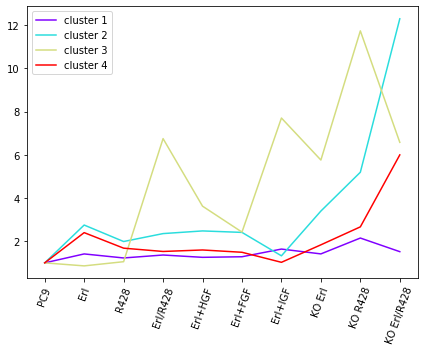

In [17]:
fig = plt.figure(figsize=(7,5))

centers = gmm_plsr.named_steps.gmm.transform(data).T

for i in range(centers.shape[0]):
    plt.plot(centers.iloc[i,:], label = "cluster "+str(i+1), color = colors_[i])
    
plt.legend()
plt.xticks(np.arange(centers.shape[1]), (treatments), rotation=70);

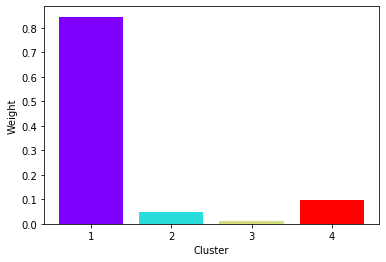

In [18]:
weights = gmm_plsr.named_steps.gmm.weights()

plt.bar(np.linspace(1, weights.size, weights.size), weights, color=colors_);
plt.xticks(np.linspace(1, weights.size, weights.size))
plt.xlabel('Cluster');
plt.ylabel('Weight');